In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
I = cv2.imread('sun.jpg') 
I_BGR = cv2.split(I)

#creating hist
histSize = 256
histRange = (0,256)
bHist = cv2.calcHist(I_BGR, [0], None, [histSize], histRange)
gHist = cv2.calcHist(I_BGR, [1], None, [histSize], histRange)
rHist = cv2.calcHist(I_BGR, [2], None, [histSize], histRange)

#tranform image to float32
if I.dtype == np.uint8:
    I = I.astype(np.float32) / 255
    I_BGR = cv2.split(I)
  
#creating cumulative hist
CHb = np.cumsum(bHist) / (I.shape[0] * I.shape[1])
CHb = CHb[:, np.newaxis].astype(np.float32)
CHg = np.cumsum(gHist) / (I.shape[0] * I.shape[1])
CHg = CHg[:, np.newaxis].astype(np.float32)
CHr = np.cumsum(rHist) / (I.shape[0] * I.shape[1])
CHr = CHr[:, np.newaxis].astype(np.float32)
CH = np.concatenate([CHb, CHg, CHr], axis=1)

## 1. Гистограммы

### 1.1 Нелинейное растяжение гистограммы

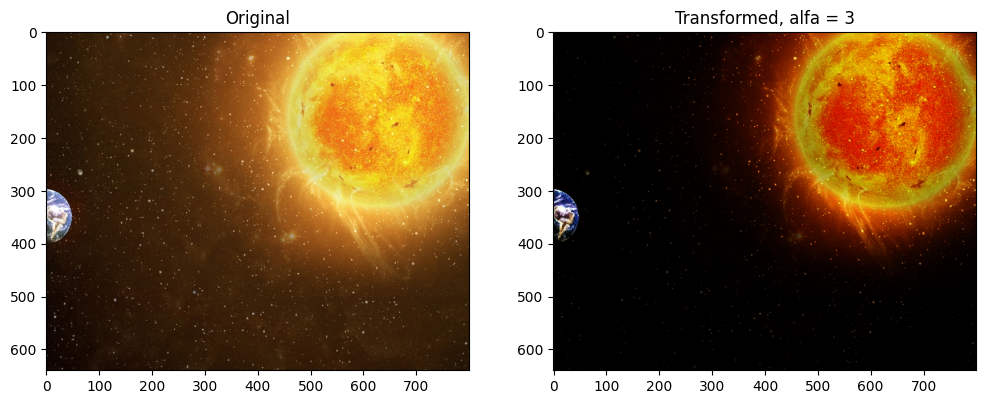

In [4]:
#tranform image to uint8
if I.dtype == np.float32:
    I = np.round(I * 255, 0).astype(np.uint8) 
    I_BGR = cv2.split(I)

alfa = 3
image_ts = np.empty_like(I, dtype=np.uint8)

for i in range(I.shape[2]):
    lut = np.arange(256, dtype = np.uint8)
    Imin = I[:,:,i].min()
    Imax = I[:,:,i].max()
    lut = (lut - Imin) / (Imax - Imin)
    lut = np.where(lut > 0, lut, 0)
    lut = np.clip(255 * np.power(lut, alfa), 0, 255)
    image_ts[:,:,i] = cv2.LUT(I[:,:,i], lut)

f, ax = plt.subplots(1,2, figsize=(12,12))
ax[0].imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original')
ax[1].imshow(cv2.cvtColor(image_ts, cv2.COLOR_BGR2RGB))
ax[1].set_title(f'Transformed, alfa = {alfa}')
plt.show()

### 1.2 Равномерное преобразование

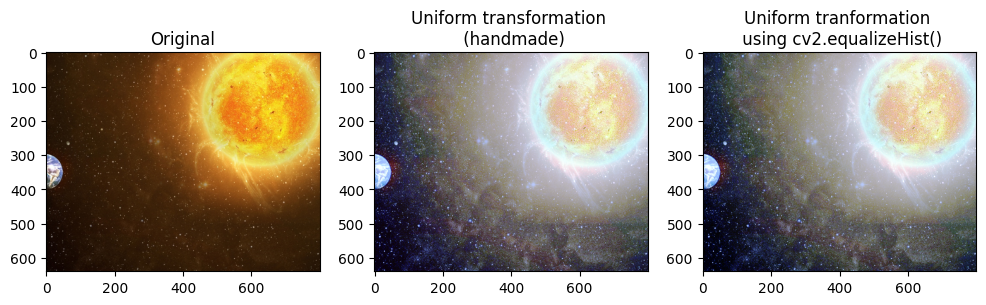

In [5]:
#tranform image to float32
if I.dtype == np.uint8 :
    I = I.astype(np.float32) / 255
    I_BGR = cv2.split(I)


Inew_BGR = []
Inew_BGR_cv = []

for i, layer in enumerate(I_BGR):
    Imin = layer.min()
    Imax = layer.max()
    Inew = np.clip((Imax-Imin)*CH[(np.round(layer*255, 0).astype(np.uint8)),i]+Imin, 0, 1)
    Inew_BGR.append(Inew)
    I_new_cv = cv2.equalizeHist((np.round(layer*255, 0).astype(np.uint8)))
    Inew_BGR_cv.append(I_new_cv)

# Merge back
Inew = cv2.merge(Inew_BGR)
Inew_cv = cv2.merge(Inew_BGR_cv)

#visualization
f, ax = plt.subplots(1,3, figsize=(12,12))
ax[0].imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original')
ax[1].imshow(cv2.cvtColor(Inew, cv2.COLOR_BGR2RGB))
ax[1].set_title(f'Uniform transformation \n (handmade)')
ax[2].imshow(cv2.cvtColor(Inew_cv, cv2.COLOR_BGR2RGB))
ax[2].set_title('Uniform tranformation \n using cv2.equalizeHist()')
plt.show()

### 1.3 Экспотенциальное преобразование

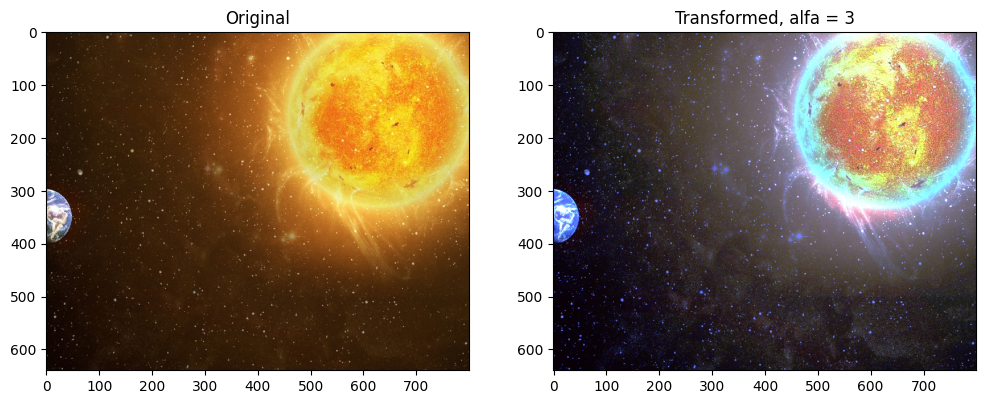

In [6]:
#tranform image to float32
if I.dtype == np.uint8 :
    I = I.astype(np.float32) / 255
    I_BGR = cv2.split(I)

alfa = 3
image_ts = np.empty_like(I, dtype=np.float32)
eps = 1e-7

for i, layer in enumerate(I_BGR):
    Imin = layer.min()
    Imax = layer.max()
    image_ts[:,:,i] = np.clip(Imin - (1 / alfa) * np.log(1 - CH[(np.round(layer*255, 0).astype(np.uint8)),i]+eps),0,1)

f, ax = plt.subplots(1,2, figsize=(12,12))
ax[0].imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original')
ax[1].imshow(cv2.cvtColor(image_ts, cv2.COLOR_BGR2RGB))
ax[1].set_title(f'Transformed, alfa = {alfa}')
plt.show()


### 1.4 Преобразование по закону Рэлея

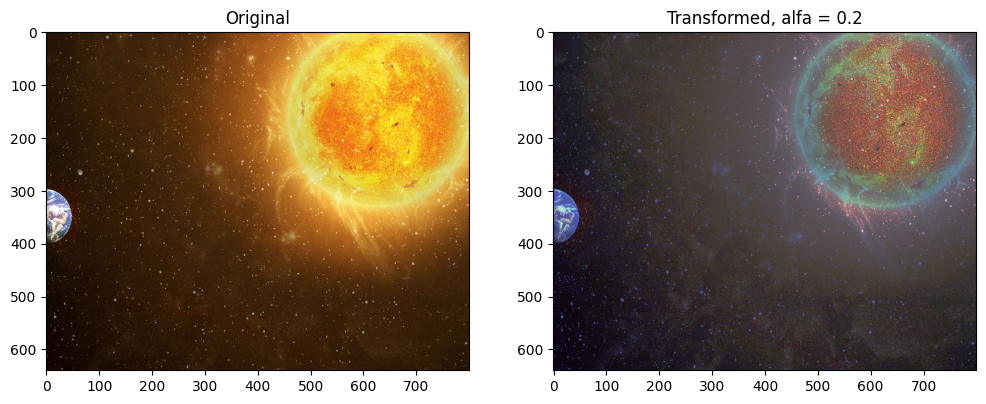

In [7]:
#tranform image to float32
if I.dtype == np.uint8 :
    I = I.astype(np.float32) / 255
    I_BGR = cv2.split(I)

alfa = 0.2
image_ts = np.empty_like(I, dtype=np.float32)
eps = 1e-7

for i, layer in enumerate(I_BGR):
    Imin = layer.min()
    Imax = layer.max()
    image_ts[:,:,i] = np.clip(Imin + (2 * alfa**2 * np.log(1 / (1 - CH[(np.round(layer*255, 0).astype(np.uint8)),i]+eps)))**0.5,0,1)

f, ax = plt.subplots(1,2, figsize=(12,12))
ax[0].imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original')
ax[1].imshow(cv2.cvtColor(image_ts, cv2.COLOR_BGR2RGB))
ax[1].set_title(f'Transformed, alfa = {alfa}')
plt.show()

### 1.5 Преобразование по закону степени 2/3

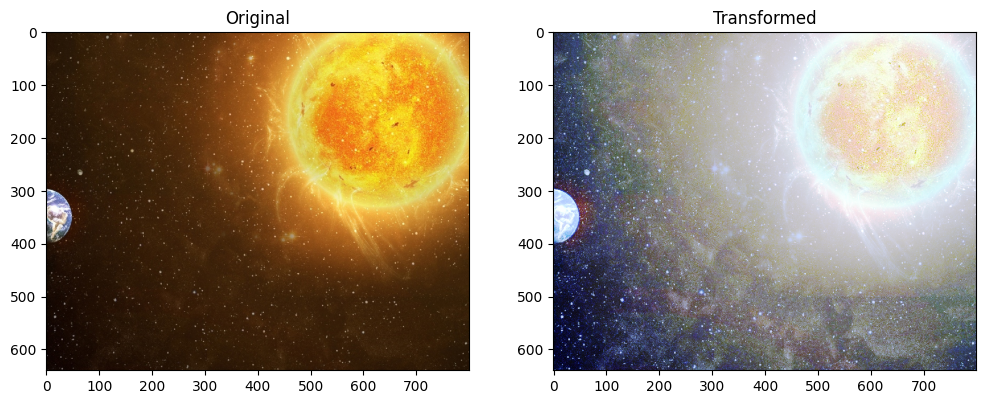

In [8]:
#tranform image to float32
if I.dtype == np.uint8 :
    I = I.astype(np.float32) / 255
    I_BGR = cv2.split(I)

image_ts = np.empty_like(I, dtype=np.float32)

for i, layer in enumerate(I_BGR):
    Imin = layer.min()
    Imax = layer.max()
    image_ts[:,:,i] = np.clip(np.power(CH[(np.round(layer*255, 0).astype(np.uint8)),i], 2./3.), 0, 1)
f, ax = plt.subplots(1,2, figsize=(12,12))
ax[0].imshow(cv2.cvtColor(I, cv2.COLOR_BGR2RGB))
ax[0].set_title('Original')
ax[1].imshow(cv2.cvtColor(image_ts, cv2.COLOR_BGR2RGB))
ax[1].set_title('Transformed')
plt.show()

### 1.6 Гиперболическое преобразование


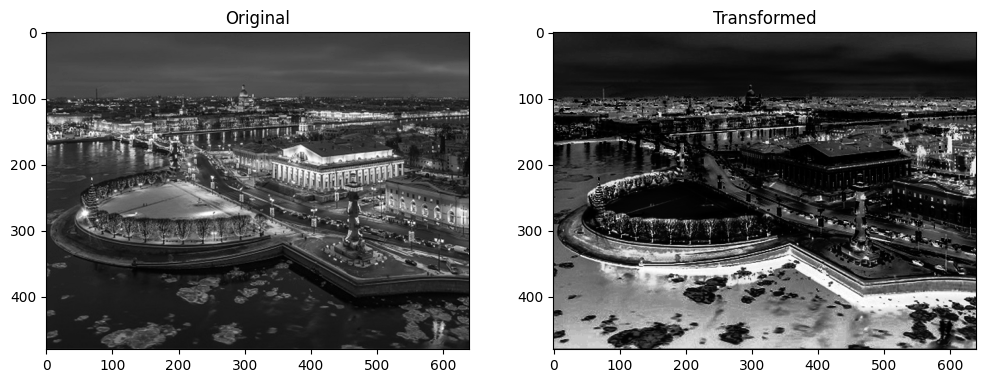

In [9]:
I = cv2.imread('spb.jpg', cv2.IMREAD_GRAYSCALE)

#creating hist
histSize = 256
histRange = (0,256)
Hist_gray = cv2.calcHist([I], [0], None, [histSize], histRange)
CH_gray = np.cumsum(Hist_gray) / (I.shape[0] * I.shape[1])

#tranform image to float32
if I.dtype == np.uint8:
    I = I.astype(np.float32) / 255

image_ts = np.empty_like(I, dtype=np.float32)

alfa  = 0.04
image_ts = np.clip(np.power(alfa, CH_gray[(np.round(I*255, 0).astype(np.uint8))]), 0, 1)

f, ax = plt.subplots(1,2, figsize=(12,12))
ax[0].imshow(I, cmap='gray')
ax[0].set_title('Original')
ax[1].imshow(image_ts, cmap='gray')
ax[1].set_title('Transformed')
plt.show()

### 1.7 CLAHE

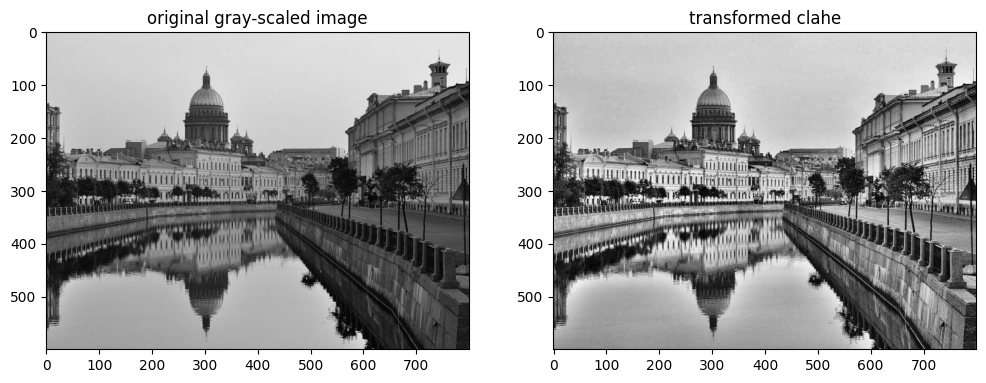

In [10]:
I = cv2.imread('spb_2.jpg', cv2.IMREAD_GRAYSCALE)


clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))

clahe_image = clahe.apply(I)

f, ax = plt.subplots(1,2, figsize=(12,12))
ax[0].imshow(I, cmap='gray')
ax[1].imshow(clahe_image, cmap='gray')
ax[0].set_title('original gray-scaled image')
ax[1].set_title('transformed clahe')
plt.show()